In [1]:
#### Descobrir o portfolio ###

In [1]:
import investpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## Ativos e Periodos

ativos = ['ITUB4', 'PETR4', 'BBDC4', 'ABEV3', 'MGLU3', 'WEGE3', 'BBAS3', \
        'VALE3', 'LAME4', 'VVAR3', 'BBDC3', 'BPAC11', 'BBSE3', 'ELET6']

fromdate = '01/01/2020'
todate = '01/08/2022'

In [3]:
## Baixa os ativos para um DF
df_precos = pd.DataFrame()

for acao in ativos:
    
    try:
        p = pd.Series(investpy.get_stock_historical_data(stock=acao,
                   country='brazil',
                   from_date= fromdate,
                   to_date= todate)['Close'],name=acao)
    
        df_precos = pd.concat([df_precos,p], axis = 1)
    except:
        pass

df_precos.dropna(how='any', inplace=True)

In [65]:
df_retornos = df_precos.pct_change(1)[1:]

In [95]:
### Cria um portfolio aleatório

def gerarPorfolio(duracao, ativos, seed = 0, variacao = 0.05):

    if seed != 0:
        np.random.seed(seed)

    m = np.zeros((duracao,ativos))

    ini = np.random.uniform(0,1,ativos)
    m[0] = ini/sum(ini)
    m_1 = m[0]

    for i in range(len(m)-1):
        add = np.random.normal(0,variacao/ativos,ativos)
        temp = m[i] + add
        m[i+1] = temp/sum(temp)
        

    return m


In [125]:
masterFIA = gerarPorfolio(250,len(df_retornos.T))

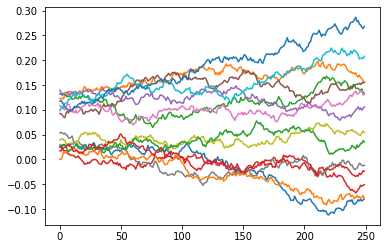

In [126]:
plt.plot(masterFIA)
plt.show()

In [129]:
cota = np.cumprod(1+np.diag(df_retornos.iloc[0:250,0:len(df_retornos.T)].dot(masterFIA.T)))
cota

array([0.99120508, 0.98792409, 0.98358285, 0.97792741, 0.9764237 ,
       0.9707824 , 0.99423656, 1.00026549, 0.9920843 , 0.99802159,
       1.01501804, 1.02164583, 1.00882949, 1.02014228, 1.03964628,
       1.03614853, 1.00004602, 1.02439745, 1.01713427, 1.01677581,
       0.9950468 , 1.00498689, 1.01451961, 1.02623706, 1.02078716,
       1.0065606 , 0.99849427, 1.03002949, 1.04310929, 1.0396587 ,
       1.02293415, 1.02978238, 1.02677934, 1.0507831 , 1.033636  ,
       1.03930418, 0.96180637, 0.93235547, 0.93800881, 0.96784107,
       0.95977856, 0.97506515, 0.92467903, 0.86404437, 0.74576603,
       0.81570338, 0.75372003, 0.62371341, 0.72662802, 0.60348375,
       0.61996424, 0.52676264, 0.53984429, 0.53558494, 0.51094684,
       0.58087783, 0.63272523, 0.64545439, 0.61048813, 0.61532167,
       0.60367444, 0.57802162, 0.5853713 , 0.56500702, 0.59917738,
       0.63134815, 0.66887433, 0.66243621, 0.67638362, 0.69219467,
       0.68738233, 0.68361874, 0.68991581, 0.69654335, 0.72638

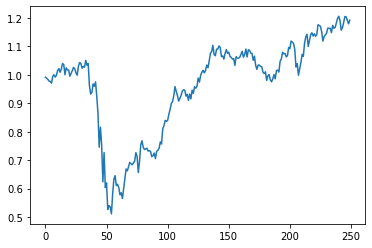

In [130]:
plt.plot(cota)
plt.show()